# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Write up Link

Link to Write up: [https://medium.com/@successengineer/lane-finding-with-computer-vision-techniques-bad24828dbc0?sk=f8c7bc5d9a9eb50c06d91867abcc2bed](https://medium.com/@successengineer/lane-finding-with-computer-vision-techniques-bad24828dbc0?sk=f8c7bc5d9a9eb50c06d91867abcc2bed)

## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

## Practice reading in an Image and Isolate White and Yellow

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


<IPython.core.display.Javascript object>


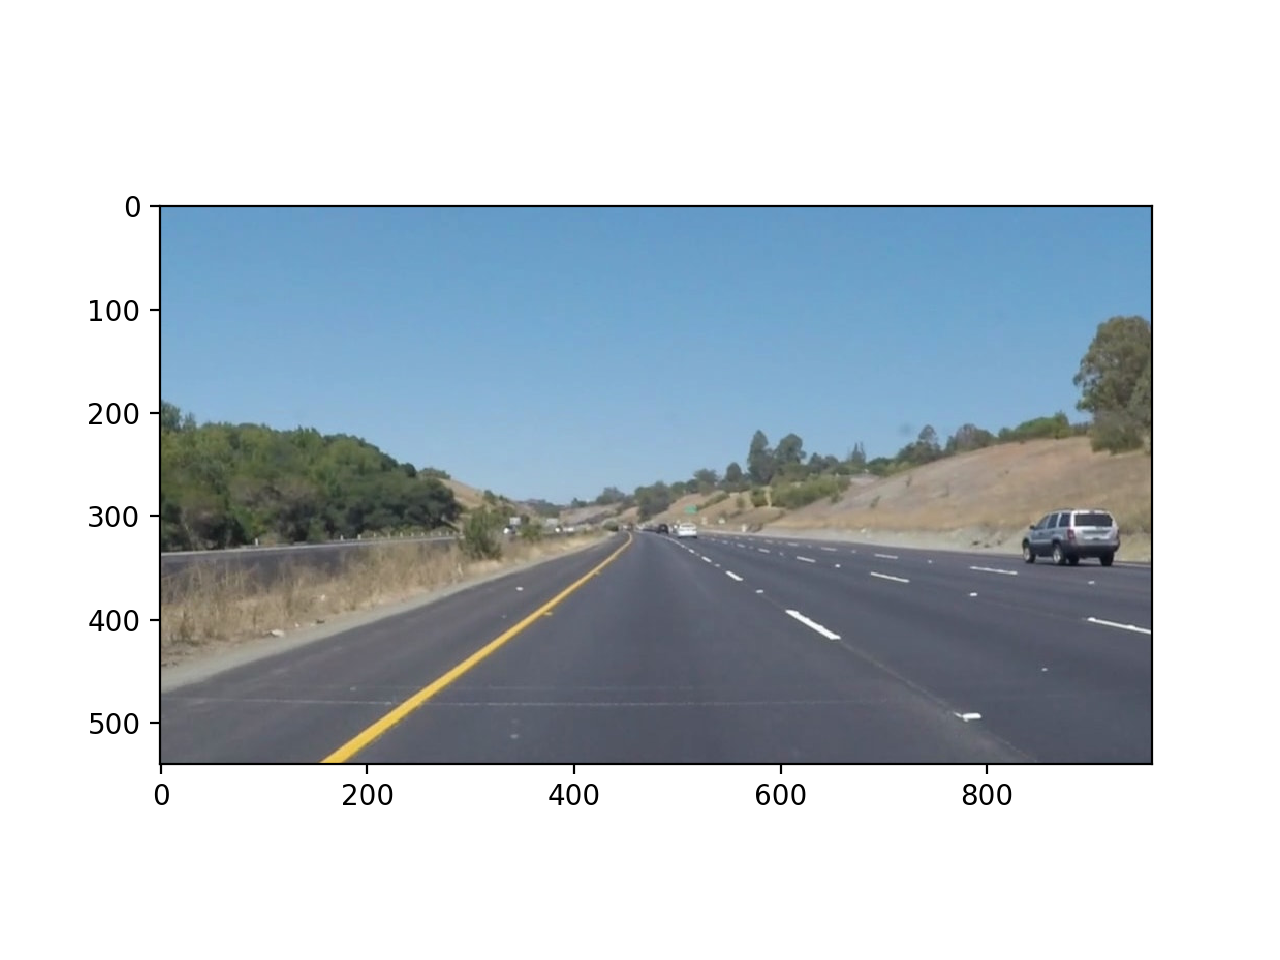

<IPython.core.display.Javascript object>


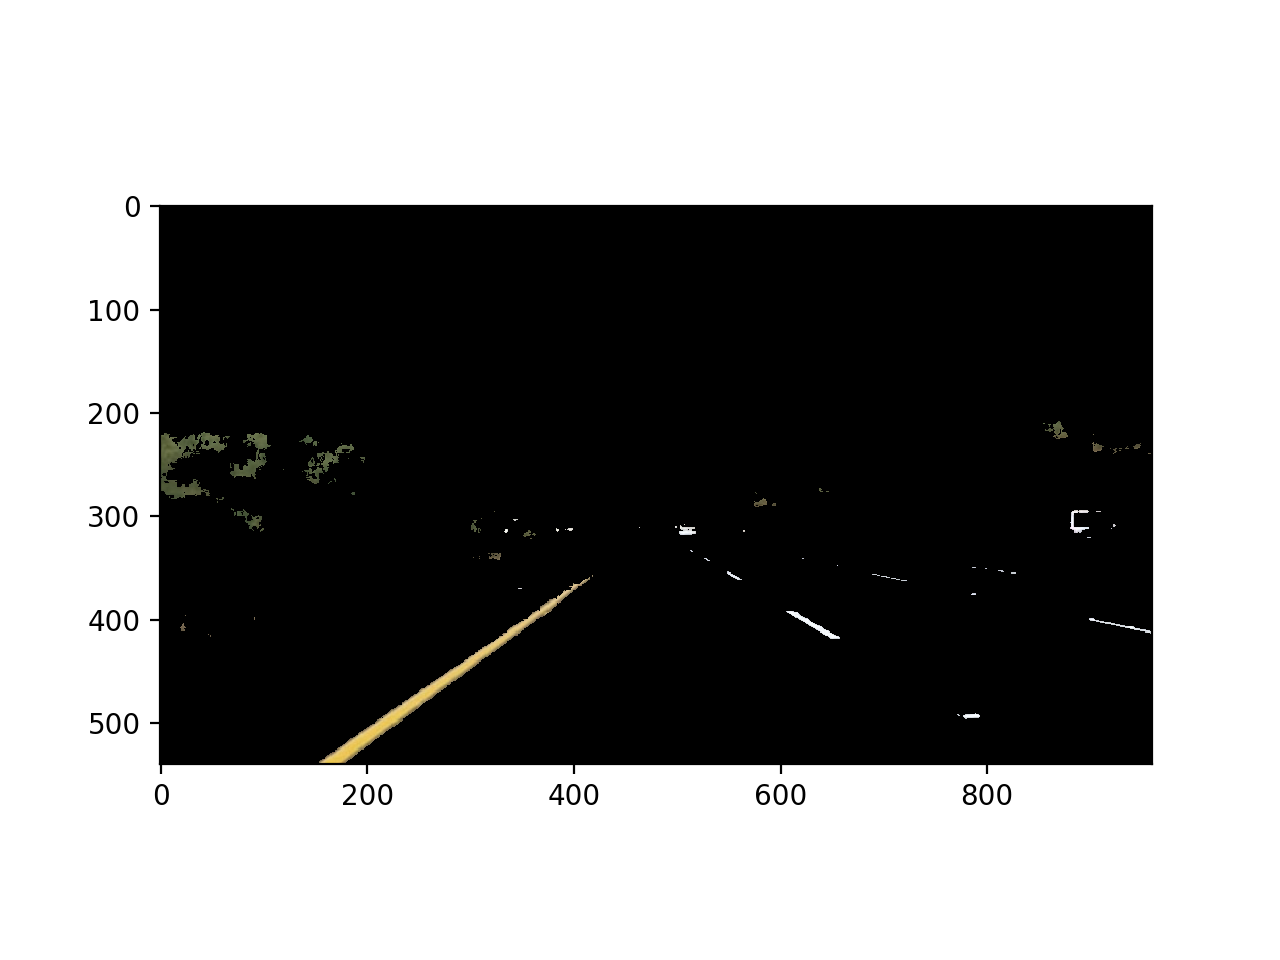

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
fig, axes = plt.subplots()
axes.imshow(image)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# define range of colors in HSV
# https://www.rapidtables.com/convert/color/hsv-to-rgb.html
lower_yellow = np.array([30,80,80])
upper_yellow = np.array([255,255,255])
lower_white = np.array([0,0,200])
upper_white = np.array([255,20,255])

# Threshold the HSV image to get only blue colors
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
white_mask = cv2.inRange(hsv, lower_white, upper_white)
mask = cv2.bitwise_or(yellow_mask, white_mask)

# Bitwise-AND mask and original image
color_isolated = cv2.bitwise_and(image, image, mask=mask)

fig, axes = plt.subplots()
axes.imshow(color_isolated)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'challenge.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'challenge.png',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
# Read in and grayscale the image
def draw_lanes_on_img(image, history = np.array([[0, 0, 0, 0]]), debug = False):

    # Convert image to HSV colorspace
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range of blue color in HSV
    lower_yellow = np.array([30,80,80])
    upper_yellow = np.array([255,255,255])
    lower_white = np.array([0,0,200])
    upper_white = np.array([255,20,255])

    # Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    mask = cv2.bitwise_or(yellow_mask, white_mask)

    # Bitwise-AND mask and original image
    color_isolated = cv2.bitwise_and(image, image, mask=mask)

    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(color_isolated)
    
    gray = cv2.cvtColor(color_isolated,cv2.COLOR_RGB2GRAY)
    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(gray, 'gray')

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(blur_gray, 'gray')
    # TODO: CREATE A CUSTOM KERNEL WITH LANES

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(edges, 'gray')

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # Define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([
        [
            (0,imshape[0]), # bottom left
            (imshape[1] * .35, imshape[0] * .6),  # top left 
            (imshape[1] * .65, imshape[0] * .6), # top right
            (imshape[1],imshape[0]) # bottom right
        ]
    ], dtype=np.int32)
    
    # Do the Masking
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(masked_edges, 'gray')
        
        mask_image = np.copy(image)*0 # creating a blank to draw lines on
        cv2.line(mask_image,(0, imshape[0]-5),(np.int_(imshape[1] * .35), np.int_(imshape[0] * .6)),(0,255,0),10)
        cv2.line(mask_image,(np.int_(imshape[1] * .35), np.int_(imshape[0] * .6)),(np.int_(imshape[1] * .65), np.int_(imshape[0] * .6)),(0,255,0),10)
        cv2.line(mask_image,(np.int_(imshape[1] * .65), np.int_(imshape[0] * .6)),(imshape[1],imshape[0]-5),(0,255,0),10)
        cv2.line(mask_image,(0, imshape[0]-5),(imshape[1],imshape[0]-5),(0,255,0),10)
        region_image = cv2.addWeighted(image, 0.8, mask_image, 1, 0)
        fig, axes = plt.subplots()
        axes.imshow(region_image)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell) ====== USED TO BE 1
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" to calculate median m's and b's for our y = mx+b
    mxb = np.array([[0,0]])
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1) / (x2-x1)
            b = y1 + -1 * m * x1   # y = mx + b, -b + y = mx, -b = mx - y, b = y + -mx
            mxb = np.vstack((mxb, [m, b]))
            
            # TODO: FILTER OUT IRREGULAR SLOPES (SLOPES SHOULD BE SOMEWHAT CONSISTENT)

    right_m_low_threshold = 0
    right_m_high_threshold = 1
    
    median_right_m = np.median(mxb[np.argwhere(np.logical_and(mxb[:,0] > right_m_low_threshold, mxb[:,0] < right_m_high_threshold)),0])
    median_left_m = np.median(mxb[mxb[:,0] < 0,0]) # Maybe less helpful than I thought to do fancy indexing...
    median_right_b = np.median(mxb[mxb[:,0] > 0,1])
    median_left_b = np.median(mxb[mxb[:,0] < 0,1])
  
    # Calculate the Intersect point of our two lines
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Given_the_equations_of_the_lines
    x_intersect = (median_left_b - median_right_b) / (median_right_m - median_left_m)
    y_intersect = median_right_m * (median_left_b - median_right_b) / (median_right_m - median_left_m) + median_right_b

    # Calculate the X-Intercept Points
    # x = (y - b) / m
    left_bottom = (imshape[0] - median_left_b) / median_left_m
    right_bottom = (imshape[0] - median_right_b) / median_right_m
    
    if (debug):
        print(median_left_m, median_left_b, median_right_m, median_right_b)
        print(x_intersect, y_intersect)
        print(left_bottom, right_bottom)
    
    # Create a History array for smoothing
    num_frames_to_median = 19
    new_history = [left_bottom, right_bottom, x_intersect, y_intersect]
    if (history.shape[0] == 1):
        history = new_history
        for i in range(num_frames_to_median):
            history = np.vstack((history, new_history))
    elif (not(np.isnan(new_history).any())): 
        history[:-1,:] = history[1:]
        history[-1, :] = new_history

    # If we couldn't find lines on a particular frame, show it to us
    if (np.isnan(median_left_b)):
        fig, axes = plt.subplots()
        axes.imshow(masked_edges)
    
    # Calculate the smoothed line points
    left_bottom_median = np.median(history[:,0])
    right_bottom_median = np.median(history[:,1])
    x_intersect_median = np.median(history[:,2])
    y_intersect_median = np.median(history[:,3])
    
    # Draw Calculated Lines
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    try:
        cv2.line(line_image,(np.int_(left_bottom_median), imshape[0]),(np.int_(x_intersect_median), np.int_(y_intersect_median)),(255,0,0),10)
        cv2.line(line_image,(np.int_(right_bottom_median), imshape[0]),(np.int_(x_intersect_median), np.int_(y_intersect_median)),(0,0,255),10)
    except:
        print("ERROR: Lines failed to draw")

    # Draw the lines on the image
    lane_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    if (debug):
        fig, axes = plt.subplots()
        axes.imshow(lane_edges)

    return (lane_edges, history)


<IPython.core.display.Javascript object>


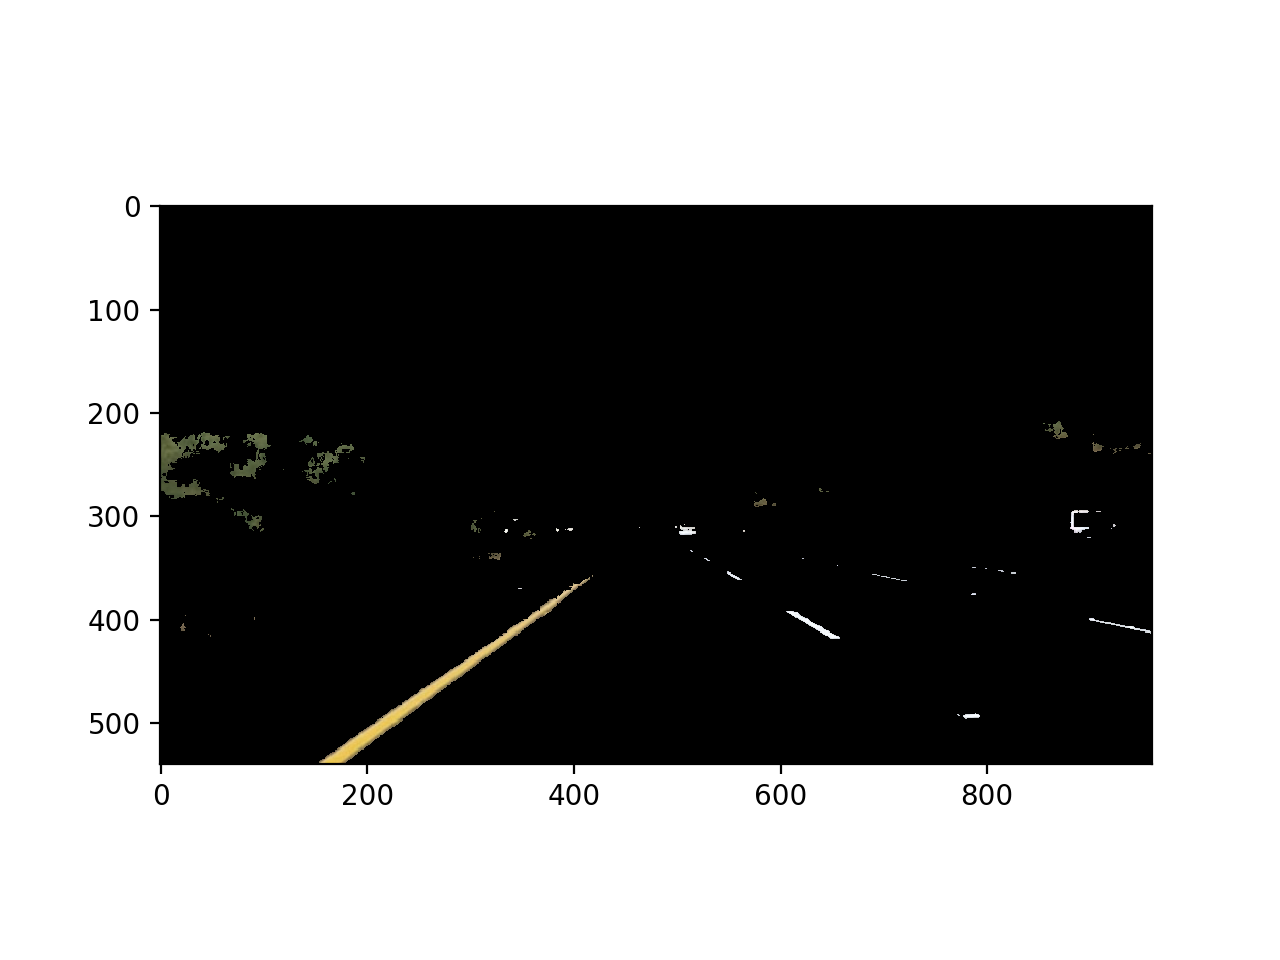

<IPython.core.display.Javascript object>


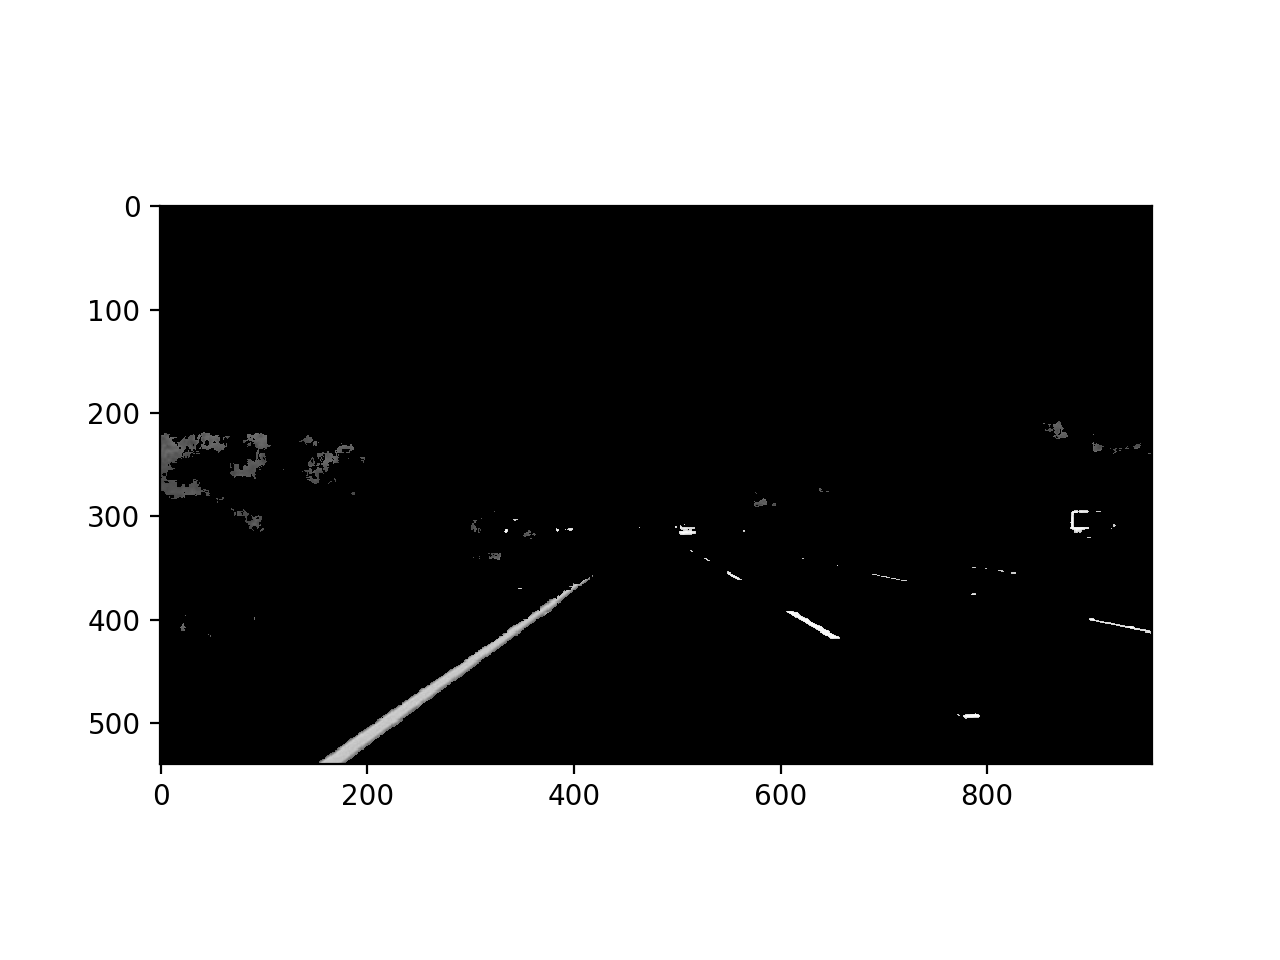

<IPython.core.display.Javascript object>


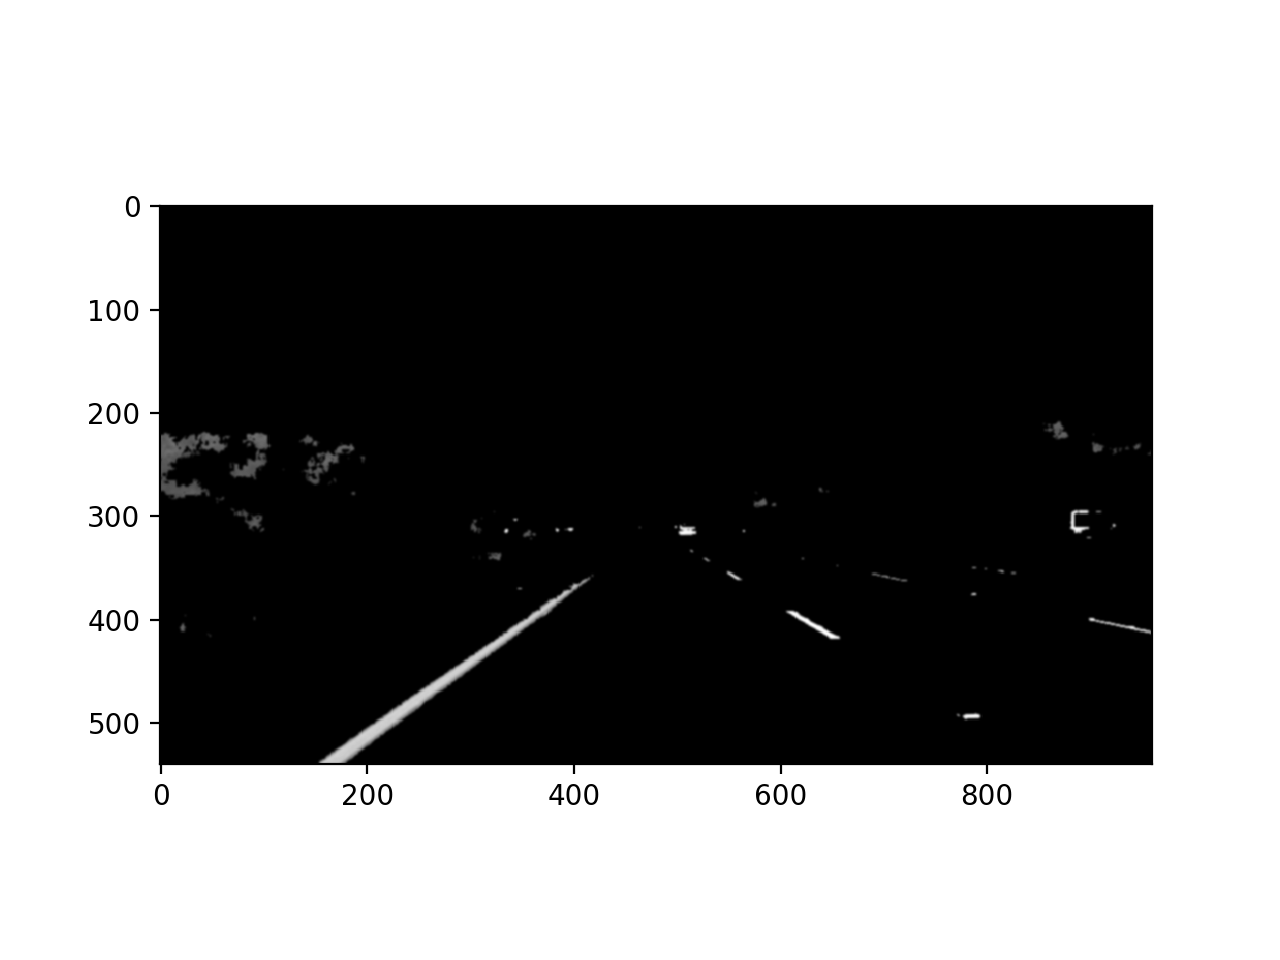

<IPython.core.display.Javascript object>


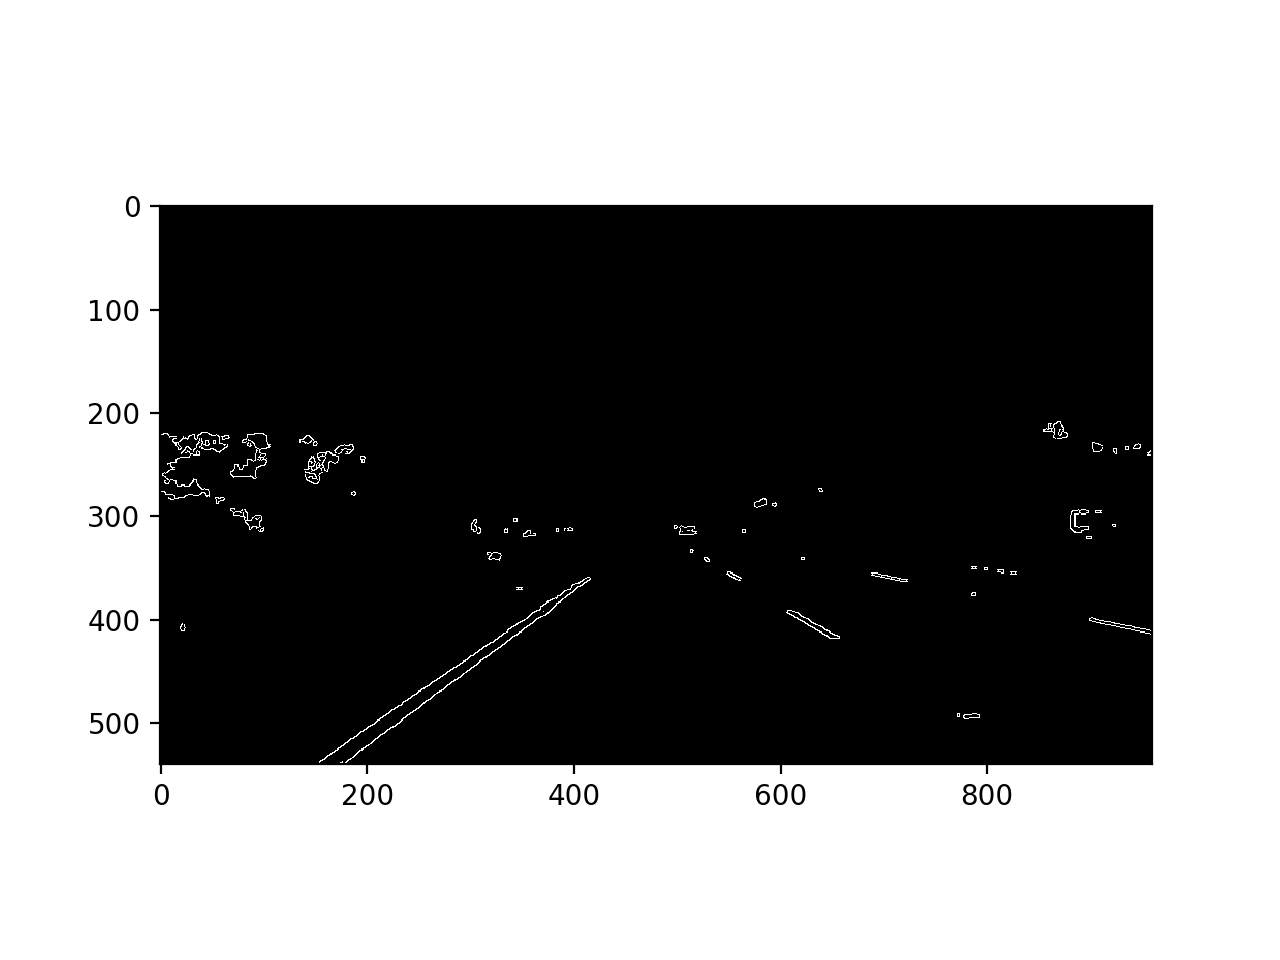

<IPython.core.display.Javascript object>


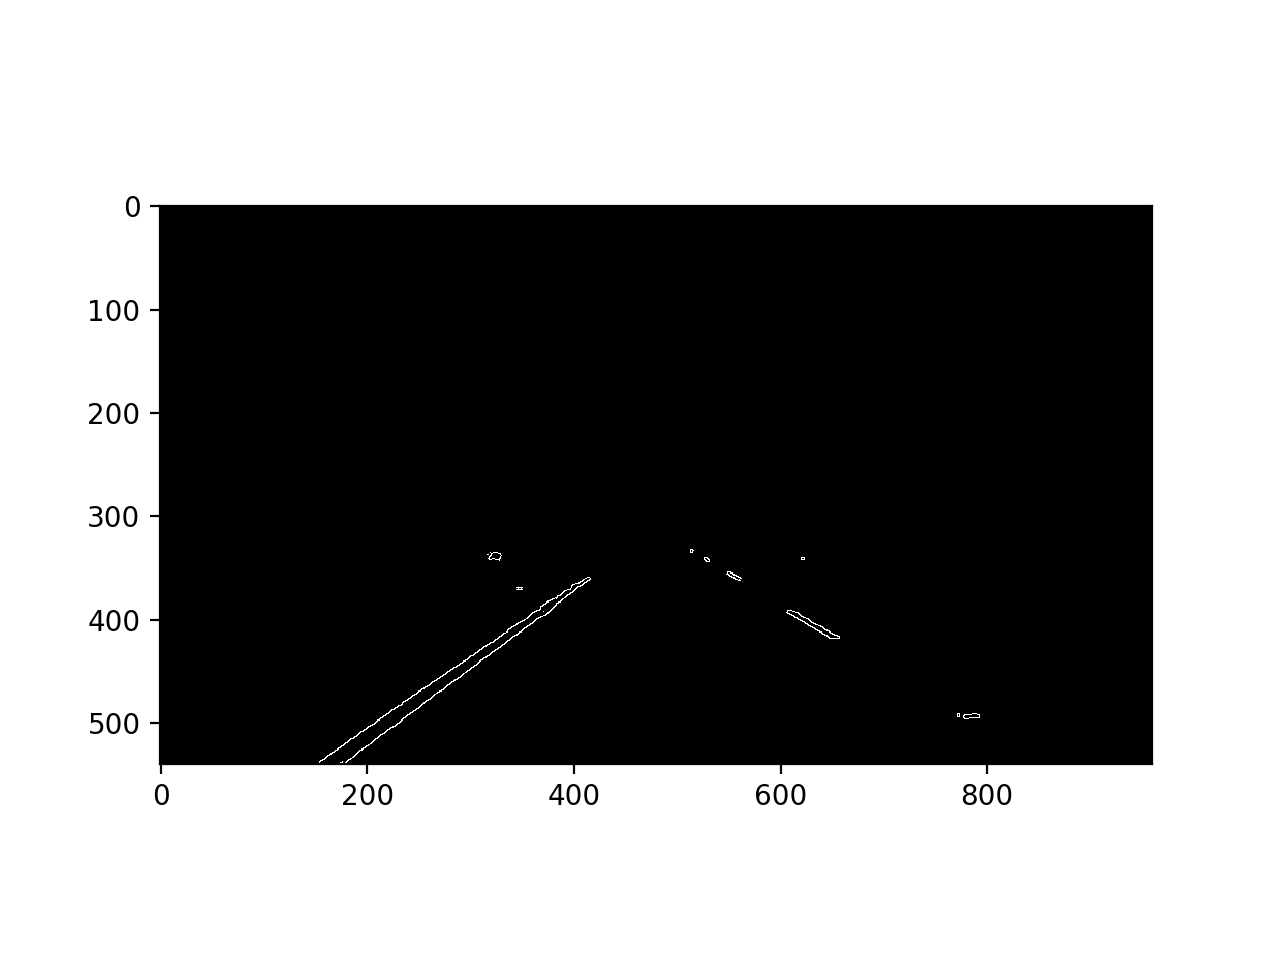

<IPython.core.display.Javascript object>


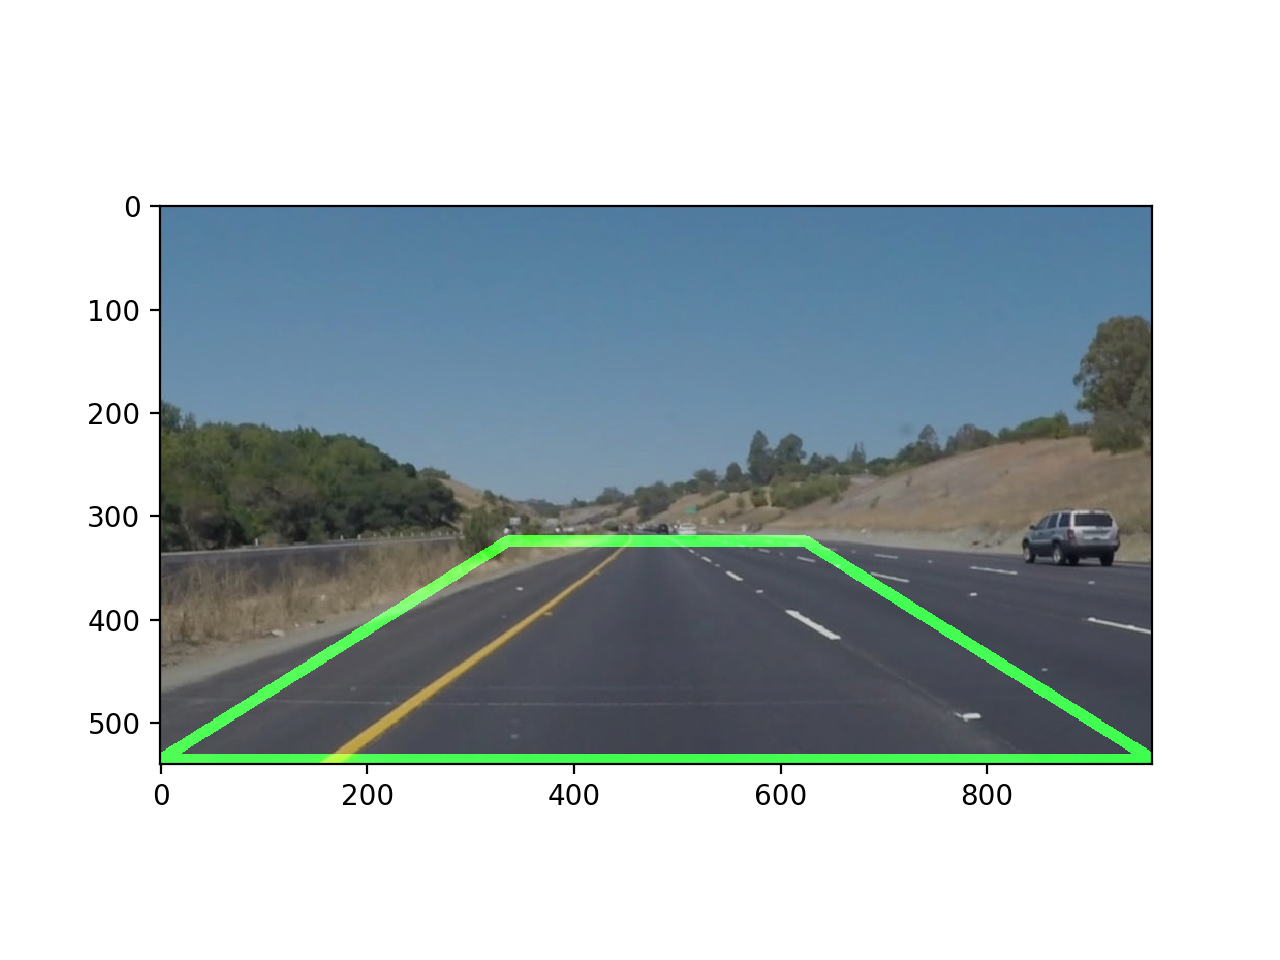

-0.702127659574 646.914893617 0.576411960133 40.8322259136
474.0429302 314.076240498
152.272727273 865.991354467


<IPython.core.display.Javascript object>


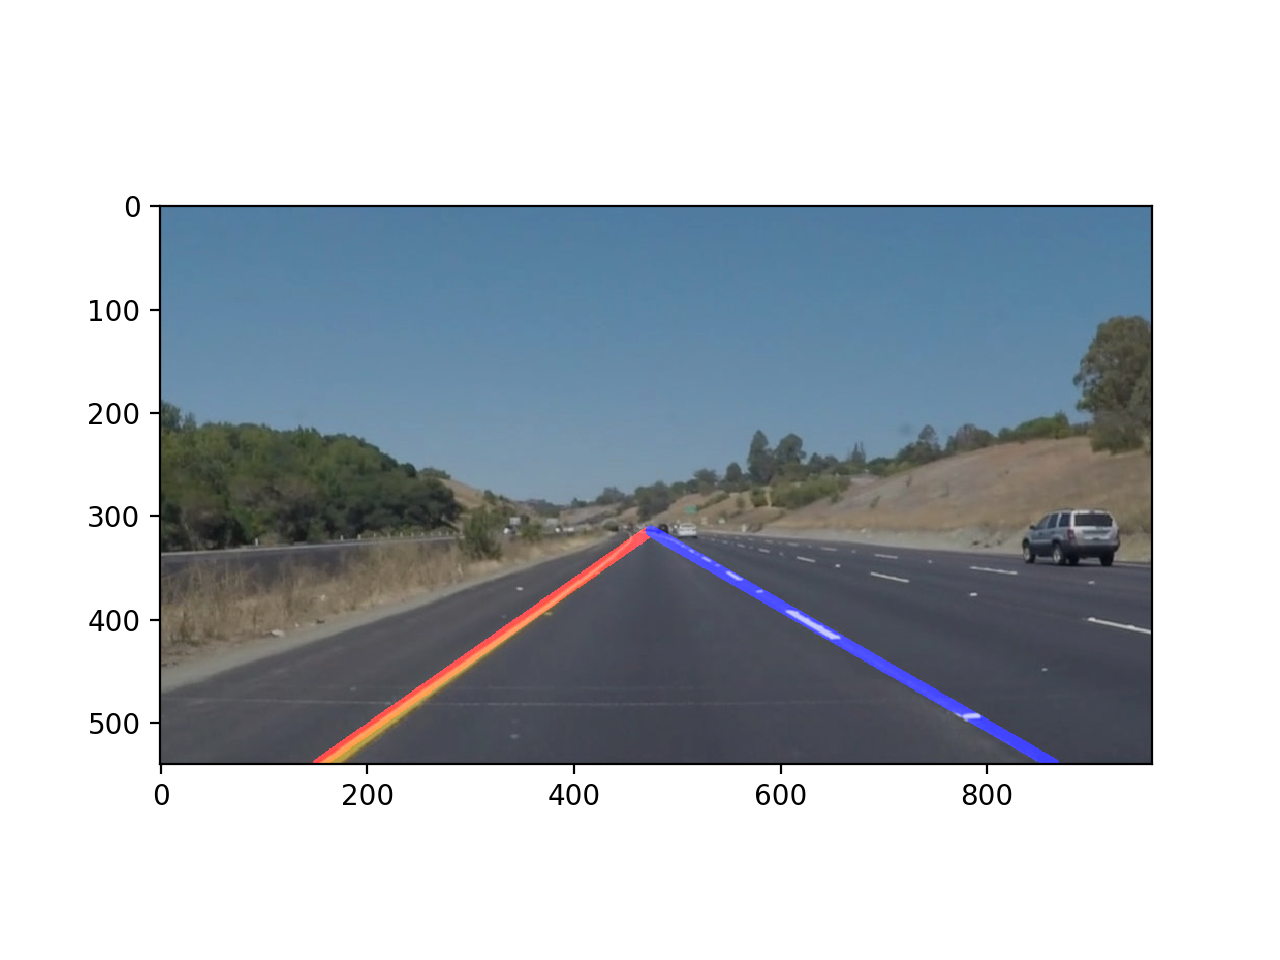

<IPython.core.display.Javascript object>


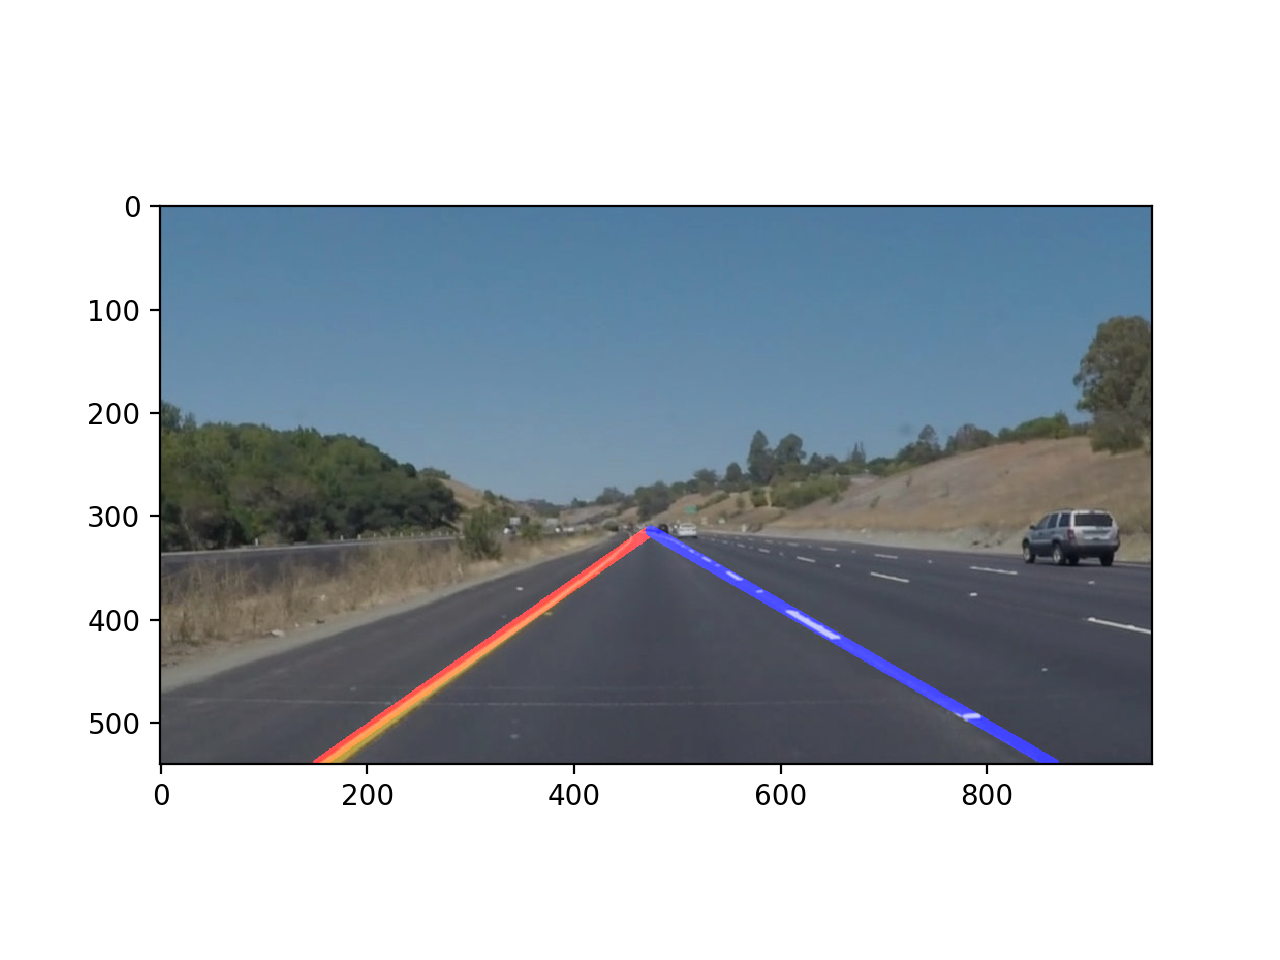

In [5]:
test_images = [
    'solidYellowCurve.jpg',
#     'solidYellowLeft.jpg',
#     'solidYellowCurve2.jpg',
#     'solidWhiteRight.jpg',
#     'whiteCarLaneSwitch.jpg',
#     'solidWhiteCurve.jpg',
#     'challenge.jpg'
]

for image_name in test_images:
    # Read Image
    image = mpimg.imread(f"test_images/{image_name}")
    
    # Transform Image
    [annotated_image, history] = draw_lanes_on_img(image, debug=True)

    # Show Image
    fig, axes = plt.subplots()
    axes.imshow(annotated_image)
    
    # Save Image to the test_images_output directory.
    mpimg.imsave(f"test_images_output/{image_name}", annotated_image.astype(np.uint8))
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

In [7]:
def process_video(input_filename, output_filename):
    history = np.array([[0, 0, 0, 0]]) # Initialize History
    images_list = []

    base_clip = VideoFileClip(input_filename)

    for frame in base_clip.iter_frames():
        [annotated_image, history] = draw_lanes_on_img(frame, history, debug=False)
        images_list.append(annotated_image)

    clip = ImageSequenceClip(images_list, fps=base_clip.fps)

    %time clip.write_videofile(output_filename, audio=False)

Let's try the one with the solid white lane on the right first ...

In [8]:
video_input = "test_videos/solidWhiteRight.mp4"
video_output = "test_videos_output/solidWhiteRight.mp4"
process_video(video_input, video_output)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|██████████| 221/221 [00:08<00:00, 25.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 139 ms, sys: 124 ms, total: 263 ms
Wall time: 10.4 s


Play the video inline

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
video_input = "test_videos/solidYellowLeft.mp4"
video_output = "test_videos_output/solidYellowLeft.mp4"
process_video(video_input, video_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|██████████| 681/681 [00:30<00:00, 22.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 713 ms, sys: 281 ms, total: 994 ms
Wall time: 32.1 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge - ACCEPTED :D

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
video_input = "test_videos/challenge.mp4"
video_output = "test_videos_output/challenge.mp4"
process_video(video_input, video_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:21<00:00, 11.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 360 ms, sys: 147 ms, total: 507 ms
Wall time: 25 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))